# Adding noise to the EAGLE simulations
This goal of this notebook is to explore adding noise to the EAGLE simulation to make mock observations.

We will go through the different types of noise so that it is clear which one dominates the signal.  In particular, we want to explore when read out noise trades out with the sky background as the dominant noise source.

The shot noise, dark current noise, and sky background noise are all Poisson processes.  Therefore can draw from a Poisson or Gaussian (large number statistics) distribution with a sigma that is the square root of the mean value for each background source to draw random values for the noise.

Poission_noise = sigma = SQRT(meanvalue_Poisson)

e.g. D_noise = SQRT ( D )

The read out noise is a Gaussian process, therefore can draw from a Gaussian distribution with a sigma that is the mean read out noise value.  Usually, people give the read out noise like # e- RMS.  This is the approximate # of e-s per pixel, or more precisely, the # e- RMS is the standard deviation (= sigma) around the mean pixel value.

Gaussian_noise = sigma = R

Since we then add the noise in quadrature that means that we add:

Noise_total = SQRT ( Poisson_noise ^ 2 + Gaussian_noise ^2 + ... ) = SQRT ( (meanvalue_Poisson) + R^2 + ...)



In [1]:
import numpy as np
import eagle_constants_and_units as c
import cosmo_utils as csu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u

import get_halpha_SB

In [2]:
%run 'load_data.ipynb'

First, let's declare some variables from the Dragonfly Telephoto array.

We will also declare a background value, which was taken from the Gemini Sky Background spectrum.  
*Verify that this background is correct*

In [14]:
# Dragonfly info
area_lens = np.pi*(14.3/2)**2 * 48. *10.                # cm^2, 48 * 14.3 cm diameter lenses
pix_size = 2.8                                          # arcsec
ang_size_pixel  = (pix_size * (1./206265.))**2          # rad^2, the pixel size of the CCD
tau_l = 0.85                                            # transmittance of the Dragonfly lens
tau_f = 1.                                              # transmittance of the Halpha filter -- assumed for now
#B = getBackground(656.3,657.3,machine)                  # *u.photon/u.second/u.arcsec**2/u.m**2  ****already multiplied by the bandwidth***
B = 0.560633
D = 0.04       # dark current (electrons / s) 
QE=0.48 # current cameras

In [4]:
debugging = True

Adding the sky background (and the Poisson noise background from the data as well, in one go).

1. Grab sky background 
2. Multiply sky background by efficiency factors, by the aperture area, and the by square angular pixel size
3. Multiply sky background by the exposure time
4. Multiply sky background by the number of pixels in one bin
5. Make an array the shape of the data, to put the sky background and Poisson noise into
6. Draw from a random gaussian distribution of the sqrt of the background (and the data) for each element of the array
7. Return the array of sky background and Poisson noise, and the value of the sky background for a binned pixel in the exposure time

In [18]:
def add_skybackground(detsignal,numpixel):
    'Background from stuff in space'
    'background sky signal detected [B]=ph/s/arcsec^2/m^2, [B_sky]=ph/s (in a pixel)'
    B_sky = B * QE * tau_l * tau_f * area_lens*(1/100.)**2 * pix_size**2
    if debugging:
        print "DEBUGGING: the background in the bandwidth is: %s"%B
        print "DEBUGGING: the background signal, B_sky [ph/s (in a pixel)], is: %s"%B_sky
    B_sky_inexptime = B_sky*exptime
    B_sky_total     = B_sky_inexptime*numpixel    
    B_sky_array = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            B_sky_array[x][y]=np.random.normal(0,np.sqrt(B_sky_total+detsignal[x][y])) 
#            B_sky_array[x][y]=np.random.poisson(B_sky_total)
#    B_sky_array_total = B_sky_array
    if debugging:
        print "DEBUGGING: the mean total background signal, B_sky_total [electrons], is: %s"\
                %B_sky_total
        print "DEBUGGING: the total background noisy signal [electrons] ranges from: %s to %s"\
                %(np.min(B_sky_array),np.max(B_sky_array))
 
    return B_sky_total, B_sky_array

Adding the dark current. 

In [51]:
def add_darkcurrent(numpixel):
    'DarkCurrent'
    noise_from_detector = 0.0
    D_total = D*exptime*numpixel
    D_array_total = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            D_array_total[x][y]=np.random.normal(D_total,np.sqrt(D_total)) 
    if debugging:
        print "DEBUGGING: the total dark current [electrons] is: %s"%(D_total)
        print "DEBUGGING: the total dark current noisy signal [electrons] ranges from: %s to %s"\
                %(np.min(D_array_total),np.max(D_array_total))
        
    return D_array_total

Adding the read out noise.  *I don't know why the sigma was B_sky for the read out noise... it is very confusing to me*

1. Assume the exposures are an hour long, so get the number of times data read out by dividing exposure time by 3600 secounds
2. The read out noise is Gaussian distributed with the sigma, R, (10e- for Dragonfly) so return a random value draw from a Gaussian distribution with sigma R

In [49]:
def add_readoutnoise(R_squared,numpixel,expnum):
    'ReadOut Noise'
    #numexposures = exptime/3600. # hour long exposures
    numexposures = expnum
    R_squared_array = np.zeros((data.shape[0],data.shape[1]))
    R = np.sqrt(R_squared)
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
#            R_squared_array[x][y]=np.mean(np.random.normal(np.sqrt(R_squared),np.sqrt(np.sqrt(B_sky)),int(numpixel)))**2   
            R_squared_array[x][y]=np.mean(np.random.normal(0,R,int(numpixel)))**2
    R_squared_total = R_squared * round(numexposures)
    R_squared_total_array = R_squared_array * round(numexposures)
#    R_squared_total_array = R_squared_array
#    R_squared_total = R_squared
    if debugging:
        print "DEBUGGING: the R_squared value is: %s, so in %s exposures [per pixel], will have R_squared of: %s"\
                %(R_squared,numexposures,R_squared_total)
        print "DEBUGGING: the total R_squared value [electrons] multiplying by numpix read out is: %s"\
                %((R_squared_total*numpixel))
        print "DEBUGGING: the max and min R_squared values are: %s and %s" \
                %(np.max(R_squared_total_array),np.min(R_squared_total_array))
        
    return R_squared_total_array

In [53]:
def addnoise(data,resolution,log = True,R_squared=None,expnum=1, exptime=10**3*3600.,CMOS=False, debugging=True):
    """
    This function adds noise to simulated data (such as the EAGLE simulation) to create mock observations.
    The EAGLE data is logged though, so the log = True for the EAGLE stuff
    """
    binpix_size = resolution # arcsec
    numpixel = round((binpix_size/pix_size)**2)
    
    if R_squared is None:
        if CMOS:
            print "VERBOSE: Using new CMOS cameras..."
            QE = 0.70                                       # quantum efficiency of the CMOS detector
            R_squared = 2.**2                               # read noise (electrons)
        else:
            print "VERBOSE: Using old cameras..."
            QE = 0.48                                       # quantum efficiency of the CCDs
            R_squared = 10.**2                              # read noise (electrons)
    
    if debugging:
        print "DEBUGGING: R_squared is : %s" % R_squared
        print "DEBUGGING: the number of pixels is %s" % numpixel
    
    if log:
        if debugging:
            print "DEBUGGING: raise the data by 10** since was logged data before..."
        data = 10**data
    
    'total signal incident in exposure time'
    totsignal = data * exptime # ( photons / cm^2 /sr )
    'total signal detected (accounting for system efficiency)'
    detsignal = totsignal * QE * tau_l * tau_f * area_lens * ang_size_pixel * numpixel
    
    if debugging:
        print "DEBUGGING: the total object signal [electrons] detected ranges from: %s to %s"%(np.min(detsignal),np.max(detsignal))
        #print "DEBUGGING: an example of the object signal [electrons] is: %s"%detsignal[0]
    
    'Add sky background and shot noise to the signal'
    B_sky_total, B_sky_array = add_skybackground(detsignal,numpixel)
    noiseadded_signal = detsignal + B_sky_total + B_sky_array
    
    'Add read out noise to the signal:'
    R_squared_total_array = add_readoutnoise(R_squared,numpixel,expnum)
    noise_from_detector = R_squared_total_array*numpixel

    'Add dark current to the signal:'
    D_array_total = add_darkcurrent(numpixel)
    noise_from_detector = noise_from_detector + D_array_total
    
    #if debugging:
    #    print "DEBUGGING: an example total noise (not squarerooted) is: %s"%(detsignal + B_sky_array + D_array_total + R_squared_total_array*numpixel)[0]
    
    noiseadded_signal = noiseadded_signal + noise_from_detector
    
    return noiseadded_signal

To demonstrate the dependence of the different noise sources on time, I need a mock data set that I will add noise to.
How about not even using the EAGLE data at first, instead just using a circle of ones on a background of zeros (to make everything very clear!).

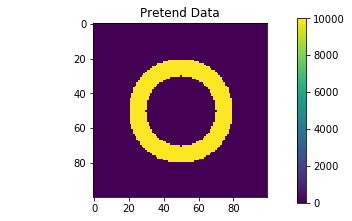

In [36]:
size = 100
pretenddata = np.zeros((size,size))
for j in np.arange(size)-size/2:
    for i in np.arange(size)-size/2:
        if np.sqrt(j**2 + i**2) < 30. and np.sqrt(j**2 + i**2) > 20. :  
            pretenddata[j+size/2,i+size/2] = 10000.
    
fig = plt.figure(figsize=(6, 3.2))
ax = fig.add_subplot(111)
ax.set_title('Pretend Data')
plt.imshow(pretenddata)
ax.set_aspect('equal')
cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

The next step is to start adding noise i.e. integrate for a small amount of time.

The add_noise function takes a couple inputs along with the data:
1. resolution
2. exposure time
3. readout noise value (optional)
4. toggle to use CMOS detectors (optional)

Let's not use the CMOS detectors, and let's use the default read out noise for now.

Let's just say we are not binning at first, so the resolution is the same as the detector (2.8").

And finally, let's use various exposure times, starting with one minute (60 seconds).

In [54]:
data = pretenddata; resolution = 2.8; exptime = 60.

noiseadded_signal = addnoise(data,resolution,log=False,exptime=exptime, expnum=1, debugging=True)

VERBOSE: Using old cameras...
DEBUGGING: R_squared is : 100.0
DEBUGGING: the number of pixels is 1.0
DEBUGGING: the total object signal [electrons] detected ranges from: 0.0 to 3.47759968285
DEBUGGING: the background in the bandwidth is: 0.560633
DEBUGGING: the background signal, B_sky [ph/s (in a pixel)], is: 13.824775167
DEBUGGING: the mean total background signal, B_sky_total [electrons], is: 829.486510018
DEBUGGING: the total background noisy signal [electrons] ranges from: -105.125583662 to 102.233320131
DEBUGGING: the R_squared value is: 100.0, so in 1 exposures [per pixel], will have R_squared of: 100.0
DEBUGGING: the total R_squared value [electrons] multiplying by numpix read out is: 100.0
DEBUGGING: the max and min R_squared values are: 1375.11450346 and 3.22975930842e-06
DEBUGGING: the total dark current [electrons] is: 2.4
DEBUGGING: the total dark current noisy signal [electrons] ranges from: -3.54096910491 to 8.34175034131


%s exists, loading now...


In [ ]:
# exposure time
exptime = 60.*60.*10**5  # seconds  (10^5 hours)
# where is the data
machine='chinook'
# what distance and resolution do you want
distance = '50Mpc'; resolution = 100
data_tuple = loaddata(machine=machine,resolution=resolution,distance=distance)
# or do you want the raw data
data_tuple = loaddata(machine=machine)
data = data_tuple[0]